In [1]:
!pip install -q medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, f1_score
from medpy.metric.binary import hd95 as compute_hausdorff95
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import find_contours
import seaborn as sns


In [3]:
# ========= CONFIG =========
CHECKPOINT_PATH = "/kaggle/input/brainmri_unet3d/tensorflow2/f32_dicemean_128x128x16/1/unet3d_best.keras"
PREDICTIONS_DIR = Path("/kaggle/working/predictions_selected")
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)
data_dir = Path("/kaggle/input/braintumor-dataset-patches")
N_CLASSES = 3
THRESHOLD_DICE_BEST = 0.85
THRESHOLD_DICE_WORST = 0.50

In [4]:
# ========= METRICS =========
def fast_dice(y_true, y_pred, epsilon=1e-7):
    """
    Compute the Dice coefficient between two binary masks.
    """
    intersection = np.sum(y_true * y_pred)
    total = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (total + epsilon)

def fast_precision(y_true, y_pred, epsilon=1e-7):
    """
    Compute the precision: TP / (TP + FP)
    """
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    return tp / (tp + fp + epsilon)

def fast_sensitivity(y_true, y_pred, epsilon=1e-7):
    """
    Compute the sensitivity (recall): TP / (TP + FN)
    """
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return tp / (tp + fn + epsilon)

def fast_specificity(y_true, y_pred, epsilon=1e-7):
    """
    Compute the specificity: TN / (TN + FP)
    """
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    return tn / (tn + fp + epsilon)

def fast_hausdorff95(y_true, y_pred):
    """
    Compute the 95th percentile Hausdorff distance.
    Returns np.nan if computation fails (e.g., empty masks).
    """
    from medpy.metric.binary import hd95
    try:
        return hd95(y_pred.reshape(128, 128, 16), y_true.reshape(128, 128, 16))
    except:
        return np.nan

In [5]:
# ========= LOAD MODEL =========

@tf.keras.utils.register_keras_serializable()
def soft_dice_loss(y_true, y_pred, axis=(2, 3, 4), epsilon=1e-7):
    """
    Compute the soft Dice loss (1 - mean Dice coefficient).

    Args:
        y_true (Tensor): Ground truth binary masks (B, C, D, H, W)
        y_pred (Tensor): Predicted masks (after sigmoid), same shape
        axis (tuple): Axes over which to compute Dice (D, H, W)
        epsilon (float): Small value to avoid division by zero

    Returns:
        Tensor: Scalar tensor (float32) representing soft Dice loss
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    numerator = 2 * K.sum(y_true * y_pred, axis=axis) + epsilon
    denominator = K.sum(K.square(y_true), axis=axis) + K.sum(K.square(y_pred), axis=axis) + epsilon

    dice = numerator / denominator
    loss = 1 - K.mean(dice)
    
    return loss


@tf.keras.utils.register_keras_serializable()
def dice_mean(y_true, y_pred, axis=(2, 3, 4), epsilon=1e-7):
    """
    Compute the mean Dice coefficient across all classes and batch elements.
    Uses keras backend (K) for compatibility and performance in mixed precision.

    Args:
        y_true (Tensor): Ground truth masks with shape (B, C, D, H, W)
        y_pred (Tensor): Predicted masks (after sigmoid activation), same shape
        axis (tuple): Axes over which to compute sums (D, H, W)
        epsilon (float): Small constant to avoid division by zero

    Returns:
        Tensor: Mean Dice coefficient (scalar)
    """
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    numerator = 2 * K.sum(y_true * y_pred, axis=axis) + epsilon
    denominator = K.sum(K.square(y_true), axis=axis) + K.sum(K.square(y_pred), axis=axis) + epsilon

    dice = numerator / denominator  # shape: (B, C)
    return K.mean(dice)  # scalar: mean over batch and class


dice_mean.__name__ = "dice_mean"


# ========= LOAD ALL VAL DATA =========
def data_generator(X_paths, y_paths):
    for x_path, y_path in zip(X_paths, y_paths):
        X = np.load(x_path)['X']  # (4, 128, 128, 16)
        y = np.load(y_path)['y']  # (3, 128, 128, 16)

        X = np.transpose(X, (0, 3, 1, 2))  # (4, 16, 128, 128)
        y = np.transpose(y, (0, 3, 1, 2))  # (3, 16, 128, 128)

        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)
        yield X, y


def get_dataset(X_paths, y_paths, batch_size=2, shuffle=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(X_paths, y_paths),
        output_types=(tf.float32, tf.float32),
        output_shapes=((4, 16, 128, 128), (3, 16, 128, 128))
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


val_X = sorted(list((data_dir / "val" / "images").glob("*.npz")))
val_y = sorted(list((data_dir / "val" / "masks").glob("*.npz")))

val_dataset = get_dataset(val_X, val_y, shuffle=False)
val_dataset = val_dataset.take(len(val_X) // 2)



strategy = tf.distribute.MirroredStrategy()
print(f"Using GPU: {strategy.num_replicas_in_sync}")

with strategy.scope():
    model = tf.keras.models.load_model(CHECKPOINT_PATH)


Using GPU: 2


In [6]:
# ========= Prediction =========
X_all, y_all = [], []
for X_batch, y_batch in val_dataset:
    X_all.append(X_batch.numpy())
    y_all.append(y_batch.numpy())
X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)
y_pred_all = model.predict(X_all, verbose=1, batch_size=2)
y_pred_bin = (y_pred_all > 0.5).astype(np.uint8)

232/232 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step


In [7]:
# ========= EVALUATE =========
samples = []
for i in range(X_all.shape[0]):
    y_true = y_all[i]
    y_pred = y_pred_bin[i]

    dice = []
    f1 = []
    sensitivity = []
    specificity = []
    precision = []
    hausdorff = []

    for c in range(N_CLASSES):
        yt = y_true[c].flatten()
        yp = y_pred[c].flatten()

        # Dice
        dice.append(fast_dice(yt, yp))

        # F1-score
        f1.append(f1_score(yt, yp, zero_division=0))

        # Sensitivity = TP / (TP + FN)
        tp = np.sum(yt * yp)
        fn = np.sum(yt * (1 - yp))
        sensitivity.append(tp / (tp + fn + 1e-7))

        # Specificity = TN / (TN + FP)
        tn = np.sum((1 - yt) * (1 - yp))
        fp = np.sum((1 - yt) * yp)
        specificity.append(tn / (tn + fp + 1e-7))

        # Precision = TP / (TP + FP)
        precision.append(tp / (tp + fp + 1e-7))

        # Hausdorff95
        try:
            hausdorff.append(compute_hausdorff95(yp.reshape(128, 128, 16), yt.reshape(128, 128, 16)))
        except:
            hausdorff.append(np.nan)

    samples.append({
        "id": i,
        "X": X_all[i],
        "y_true": y_true,
        "y_pred": y_pred,
        "dice": dice,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "hd95": hausdorff,
        "dice_mean_tc_wt_ec": np.mean(dice)
    })

In [8]:
# ========= CONVERT TO DF =========
df_results = pd.DataFrame([{
    "id": s["id"],

    # Dice
    "dice_tc": s["dice"][0],
    "dice_wt": s["dice"][1],
    "dice_ec": s["dice"][2],

    # Sensitivity
    "sens_tc": s["sensitivity"][0],
    "sens_wt": s["sensitivity"][1],
    "sens_ec": s["sensitivity"][2],

    # Specificity
    "spec_tc": s["specificity"][0],
    "spec_wt": s["specificity"][1],
    "spec_ec": s["specificity"][2],

    # Precision
    "prec_tc": s["precision"][0],
    "prec_wt": s["precision"][1],
    "prec_ec": s["precision"][2],

    # F1-score
    "f1_tc": s["f1"][0],
    "f1_wt": s["f1"][1],
    "f1_ec": s["f1"][2],

    # Hausdorff95
    "hd95_tc": s["hd95"][0],
    "hd95_wt": s["hd95"][1],
    "hd95_ec": s["hd95"][2],

    # Dice macro avg
    "dice_mean_tc_wt_ec": s["dice_mean_tc_wt_ec"]

} for s in samples])

In [9]:
# ========= SUMMARY TABLE AND SAVE =========
summary = df_results.drop(columns="id").agg(["median", "mean"]).T.round(4)
summary.to_csv(PREDICTIONS_DIR / "metrics_summary.csv")
df_results.to_csv(PREDICTIONS_DIR / "metrics_all.csv", index=False)
display(summary)

,median,mean
dice_tc,0.8345,0.8025
dice_wt,0.5861,0.5270
dice_ec,0.8391,0.6849
sens_tc,0.8511,0.8198
sens_wt,0.5753,0.5207
sens_ec,0.8788,0.7240
spec_tc,0.9916,0.9887
spec_wt,0.9985,0.9962
spec_ec,0.9982,0.9965
prec_tc,0.8374,0.8039


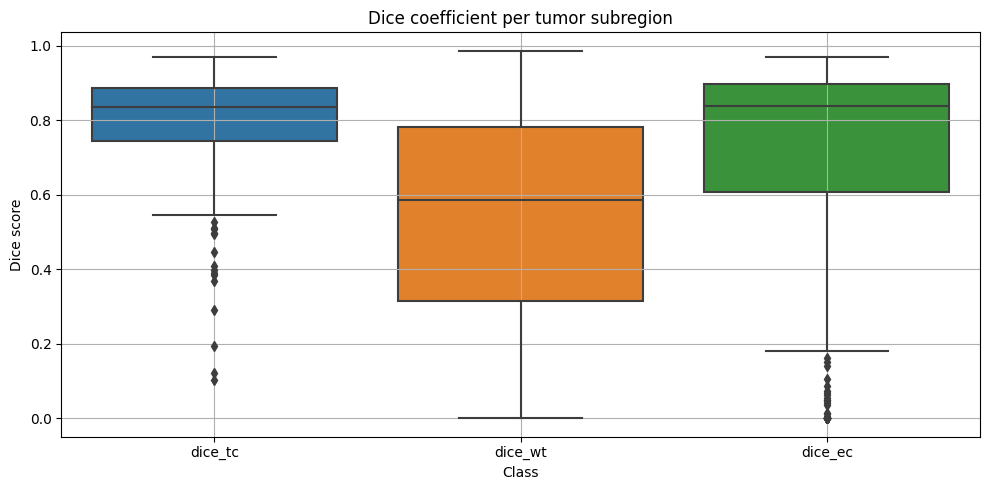

In [10]:
# ========== SANITY CHECK ==========
for i, s in enumerate(samples):
    expected = np.mean(s["dice"])
    actual = df_results.loc[i, "dice_mean_tc_wt_ec"]
    if not np.isclose(expected, actual, atol=1e-4):
        print(f"[Warning] Sample {s['id']} has inconsistent Dice mean: expected {expected}, got {actual}")

# ========== DICE BOXPLOT PER CLASS ==========
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_results[["dice_tc", "dice_wt", "dice_ec"]])
plt.title("Dice coefficient per tumor subregion")
plt.ylabel("Dice score")
plt.xlabel("Class")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# ========= SELECTING CASES TO VISUALIZE =========

# Sort samples by average Dice across TC, WT, EC
samples_sorted = sorted(samples, key=lambda x: x["dice_mean_tc_wt_ec"], reverse=True)

# Top 5 best predictions
best5 = samples_sorted[:5]

# Bottom 5 worst (below threshold)
worst5 = [s for s in reversed(samples_sorted) if s["dice_mean_tc_wt_ec"] < THRESHOLD_DICE_WORST][:5]

# Random samples per class (TC/WT/EC must be present in GT)
random_tc = random.sample([s for s in samples if s["y_true"][0].sum() > 0], k=5)
random_wt = random.sample([s for s in samples if s["y_true"][1].sum() > 0], k=5)
random_ec = random.sample([s for s in samples if s["y_true"][2].sum() > 0], k=5)

# ========= SAVE SELECTED SAMPLES =========

def save_case(s, folder):
    np.savez_compressed(
        PREDICTIONS_DIR / folder / f"case_{s['id']:04d}.npz",
        X=s["X"],
        y_true=s["y_true"],
        y_pred=s["y_pred"],
        dice=np.array(s["dice"]),
        f1=np.array(s["f1"]),
        precision=np.array(s["precision"]),
        sensitivity=np.array(s["sensitivity"]),
        specificity=np.array(s["specificity"]),
        hd95=np.array(s["hd95"]),
        dice_mean_tc_wt_ec=s["dice_mean_tc_wt_ec"]
    )

# Create subfolders for saving selected samples
for folder in ["best_dice", "worst_dice", "class_TC", "class_WT", "class_EC"]:
    (PREDICTIONS_DIR / folder).mkdir(exist_ok=True)

# Save cases
for s in best5:
    save_case(s, "best_dice")
for s in worst5:
    save_case(s, "worst_dice")
for s in random_tc:
    save_case(s, "class_TC")
for s in random_wt:
    save_case(s, "class_WT")
for s in random_ec:
    save_case(s, "class_EC")


In [12]:
def draw_contours(image, masks, class_names, colors, alpha=1.0):
    """
    Draw contours for each class on the image.

    Args:
        image: 2D background image (grayscale)
        masks: 3D array of shape (C, H, W)
        class_names: list of class names
        colors: list of matplotlib-compatible colors
        alpha: transparency for mask overlay (default 1.0)
    """
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    for c in range(masks.shape[0]):
        contours = find_contours(masks[c], 0.5)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=colors[c], label=class_names[c])

    ax.axis("off")
    return fig, ax


In [13]:
def visualize_case(npz_path, slice_idx=8, flair_idx=1):
    """
        Professional visualization of ground truth and prediction with contours.

    Args:
        npz_path (Path): Path to .npz file with 'X', 'y_true', 'y_pred'
        slice_idx (int): Which slice in depth to visualize
        flair_idx (int): Which modality index is FLAIR (default 1)
    """
    data = np.load(npz_path)
    X = data["X"]
    y_true = data["y_true"]
    y_pred = data["y_pred"]
    dice_mean_tc_wt_ec = data["dice_mean_tc_wt_ec"]


    flair = X[flair_idx, slice_idx]  # (128, 128)
    true_slice = y_true[:, slice_idx]  # (C, H, W)
    pred_slice = y_pred[:, slice_idx]  # (C, H, W)

    class_names = ["TC", "WT", "EC"]
    colors = ["green", "red", "blue"]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].imshow(flair, cmap='gray')
    axs[0].set_title("FLAIR")
    axs[0].axis("off")

    # Ground Truth with contours
    axs[1].imshow(flair, cmap='gray')
    for c in range(true_slice.shape[0]):
        contours = find_contours(true_slice[c], 0.5)
        for contour in contours:
            axs[1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=colors[c])
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    # Prediction with contours
    axs[2].imshow(flair, cmap='gray')
    for c in range(pred_slice.shape[0]):
        contours = find_contours(pred_slice[c], 0.5)
        for contour in contours:
            axs[2].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=colors[c])
    axs[2].set_title(f"Prediction\n: {dice_mean_tc_wt_ec:.3f}")

    axs[2].axis("off")

    plt.suptitle(f"{npz_path.name}", fontsize=14)
    plt.tight_layout()
    plt.show()



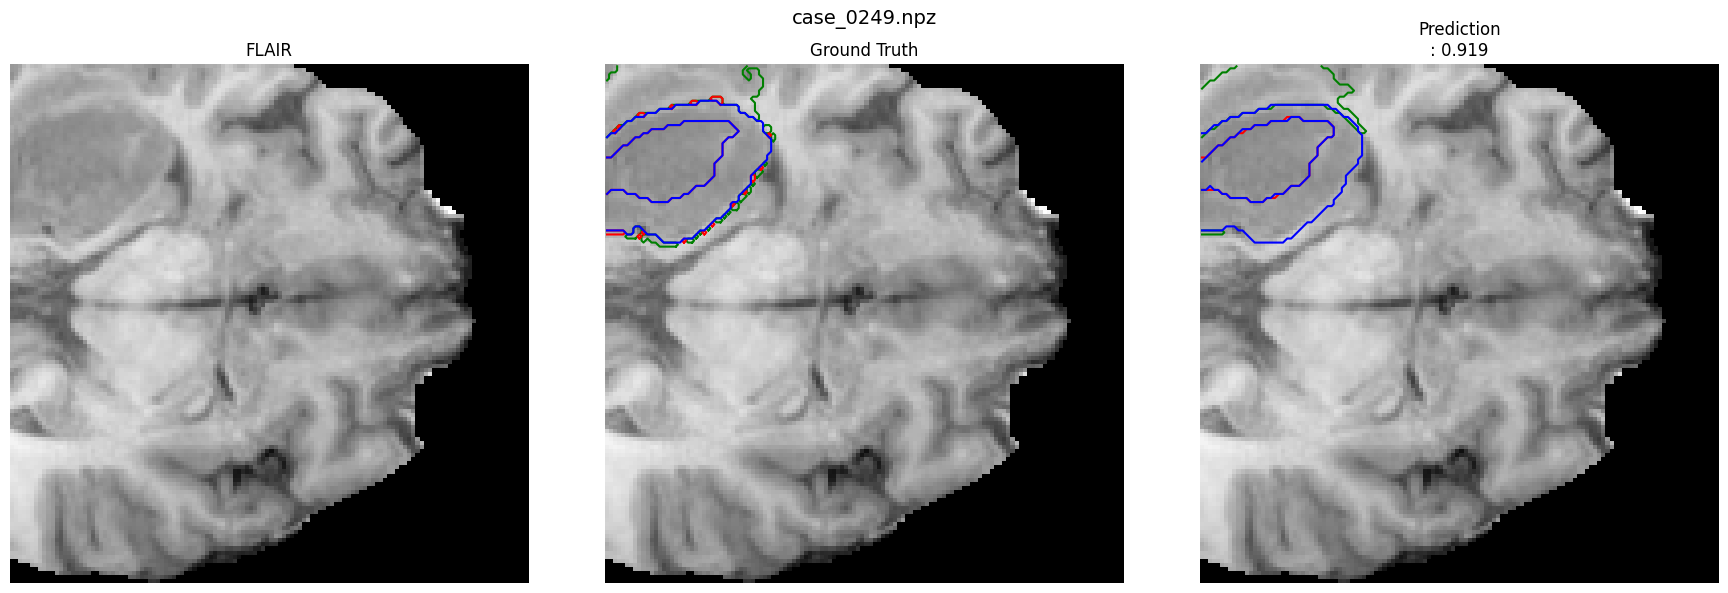

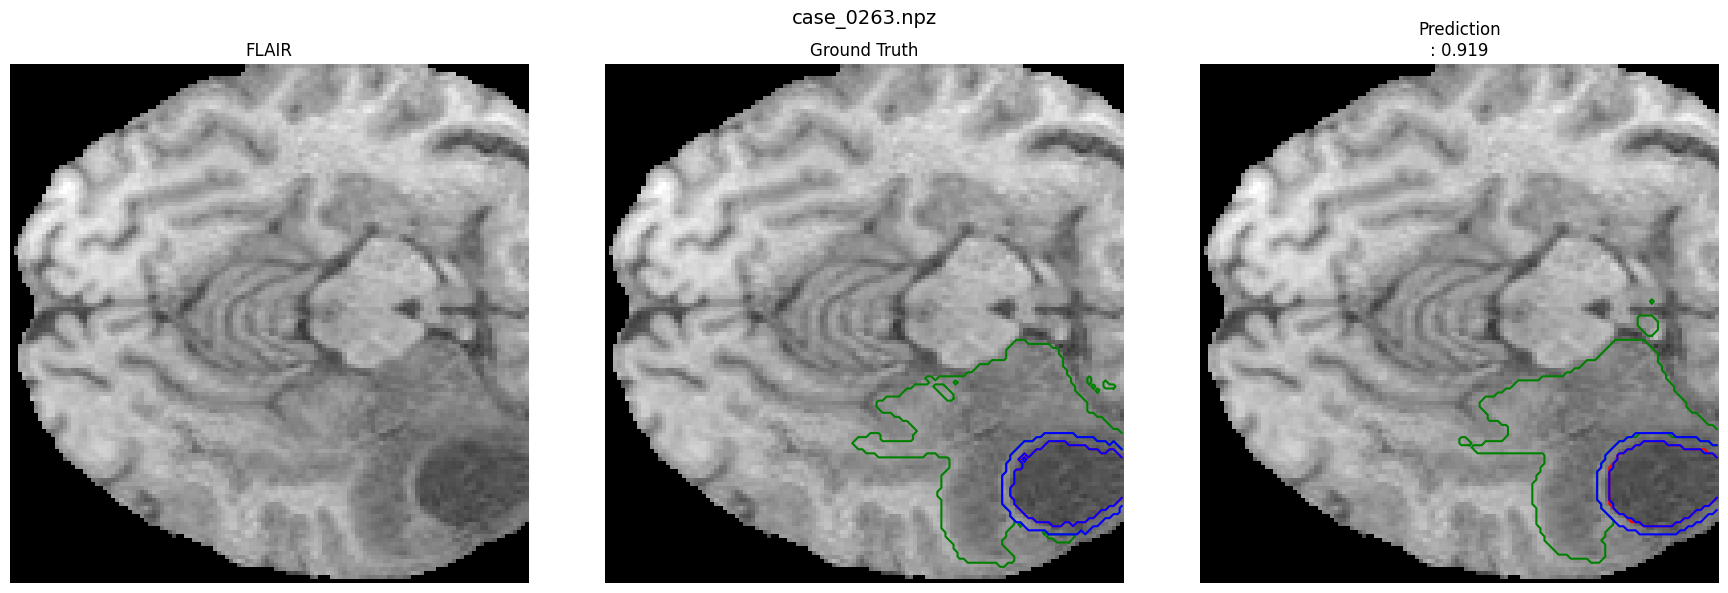

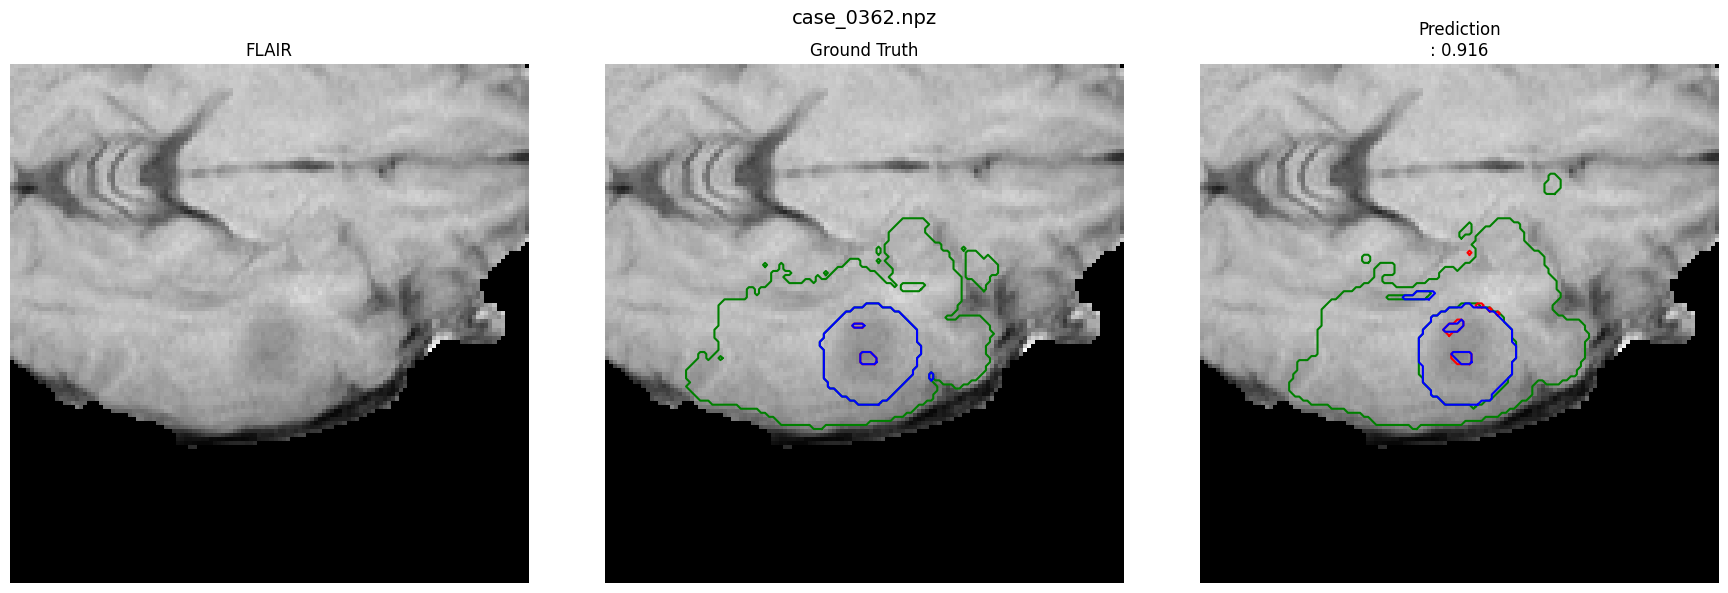

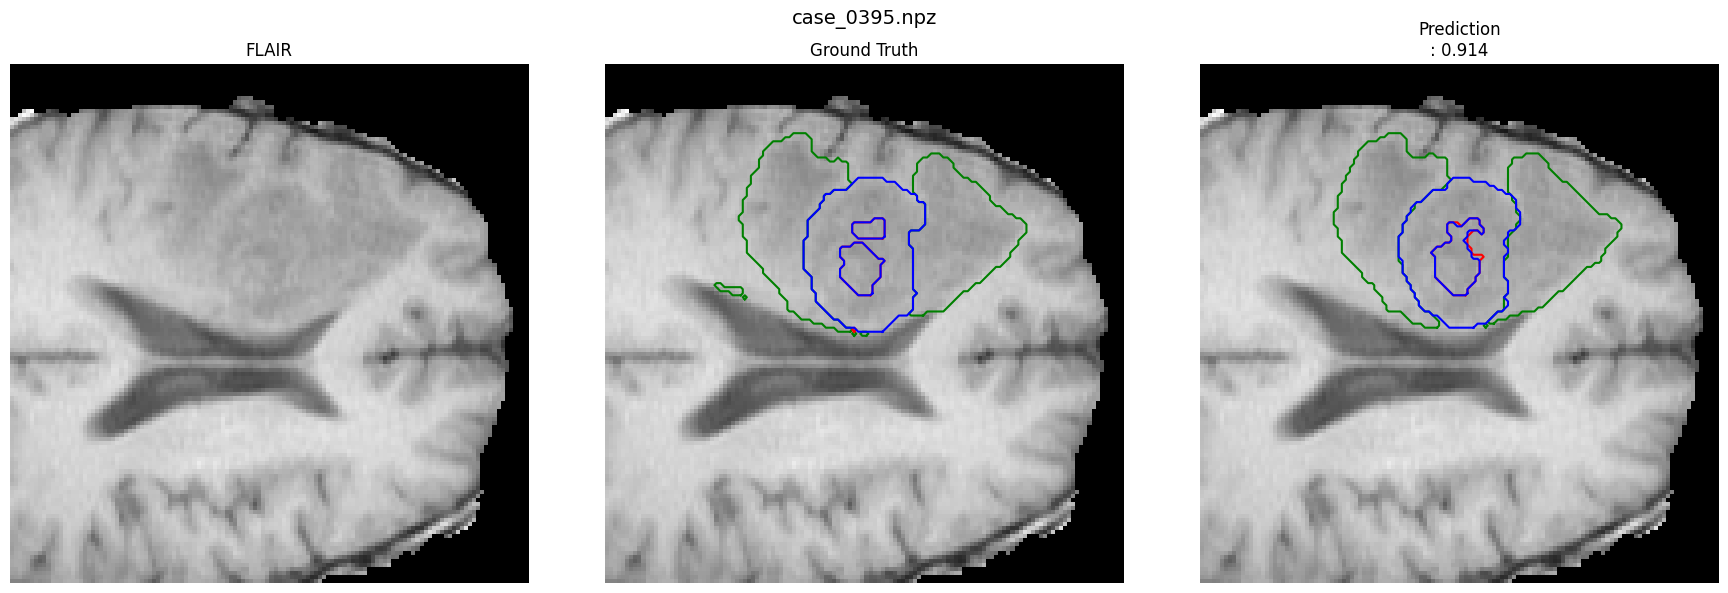

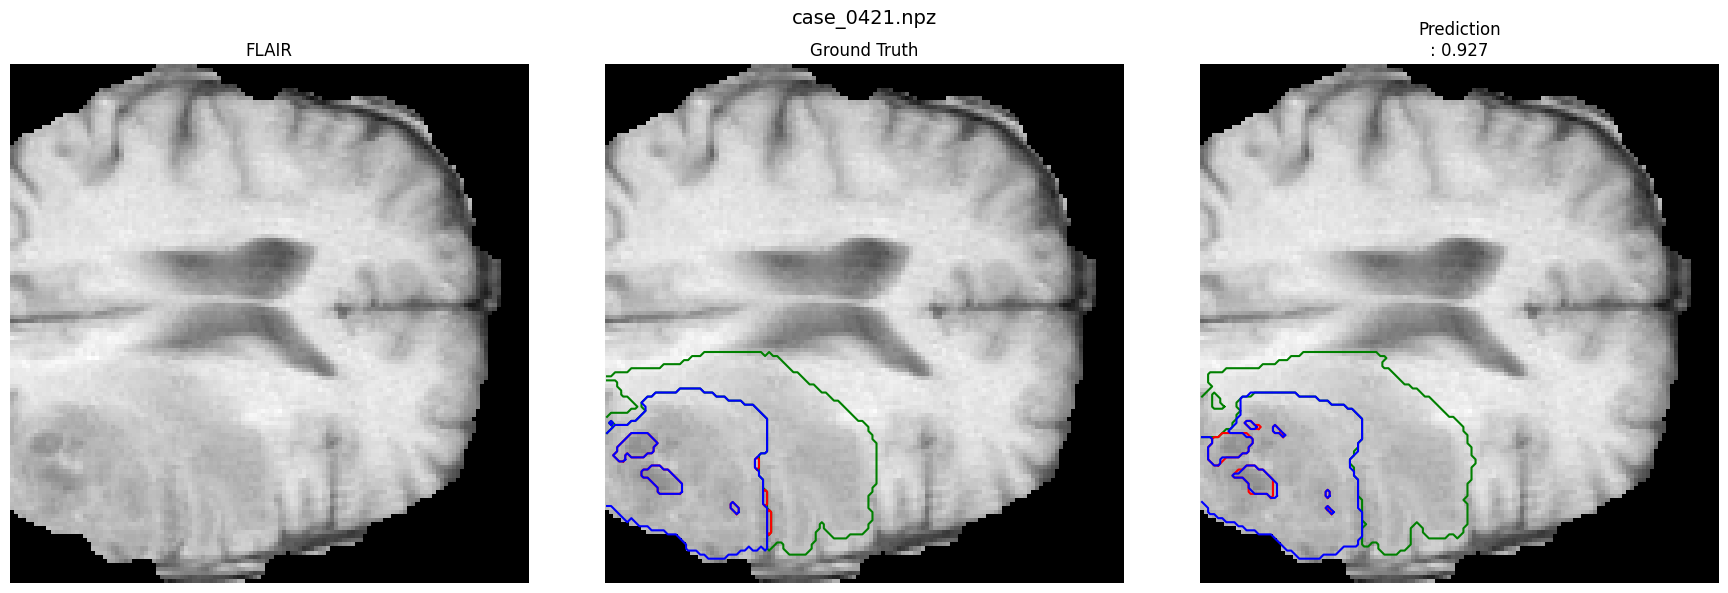

In [14]:
folder = PREDICTIONS_DIR / "best_dice"
files = sorted(folder.glob("*.npz"))

for file in files:
    visualize_case(file, slice_idx=8)

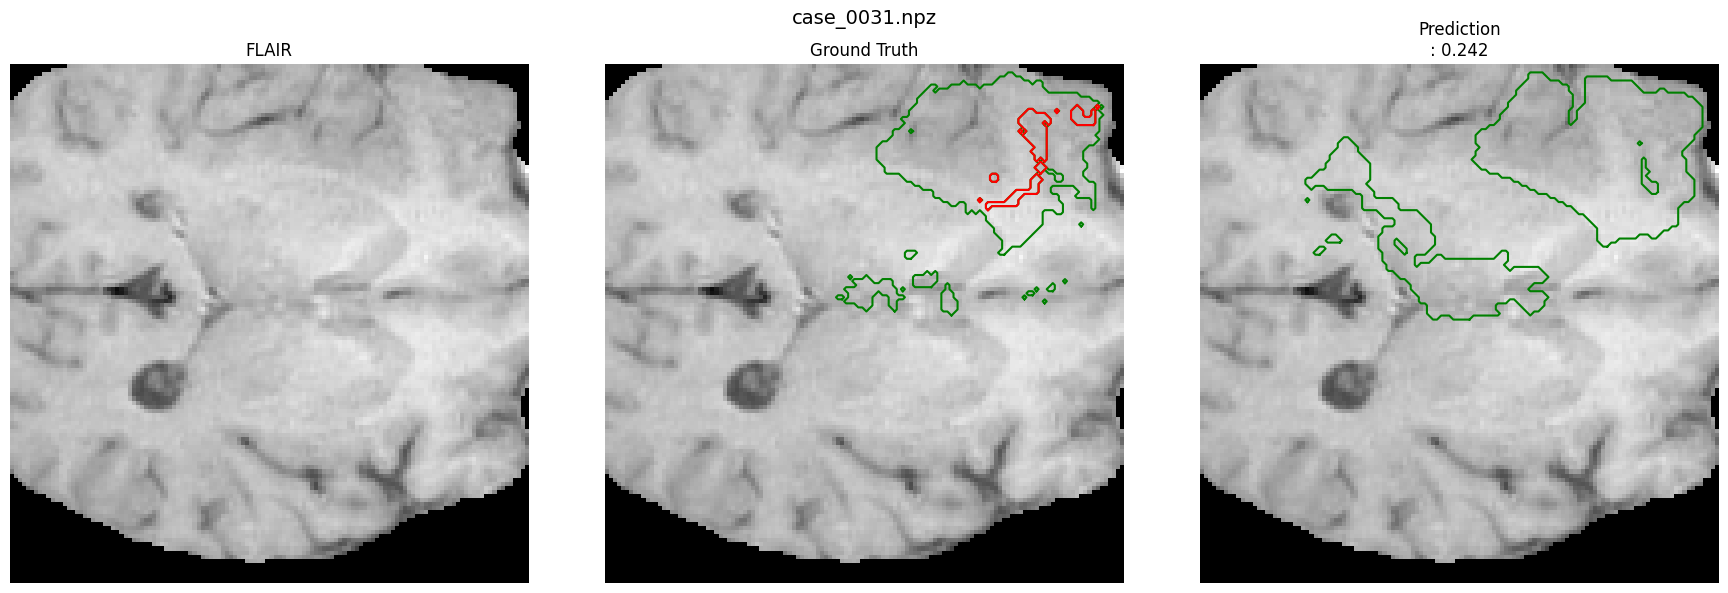

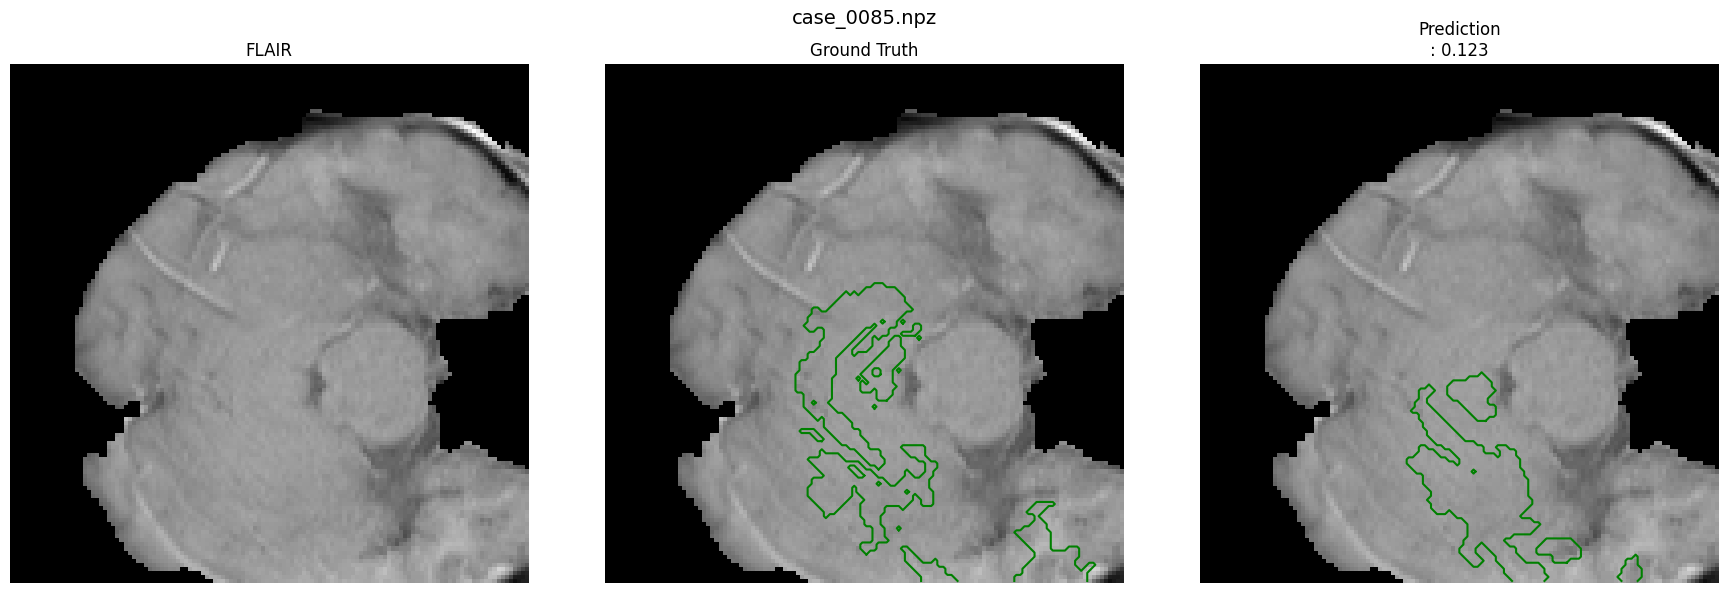

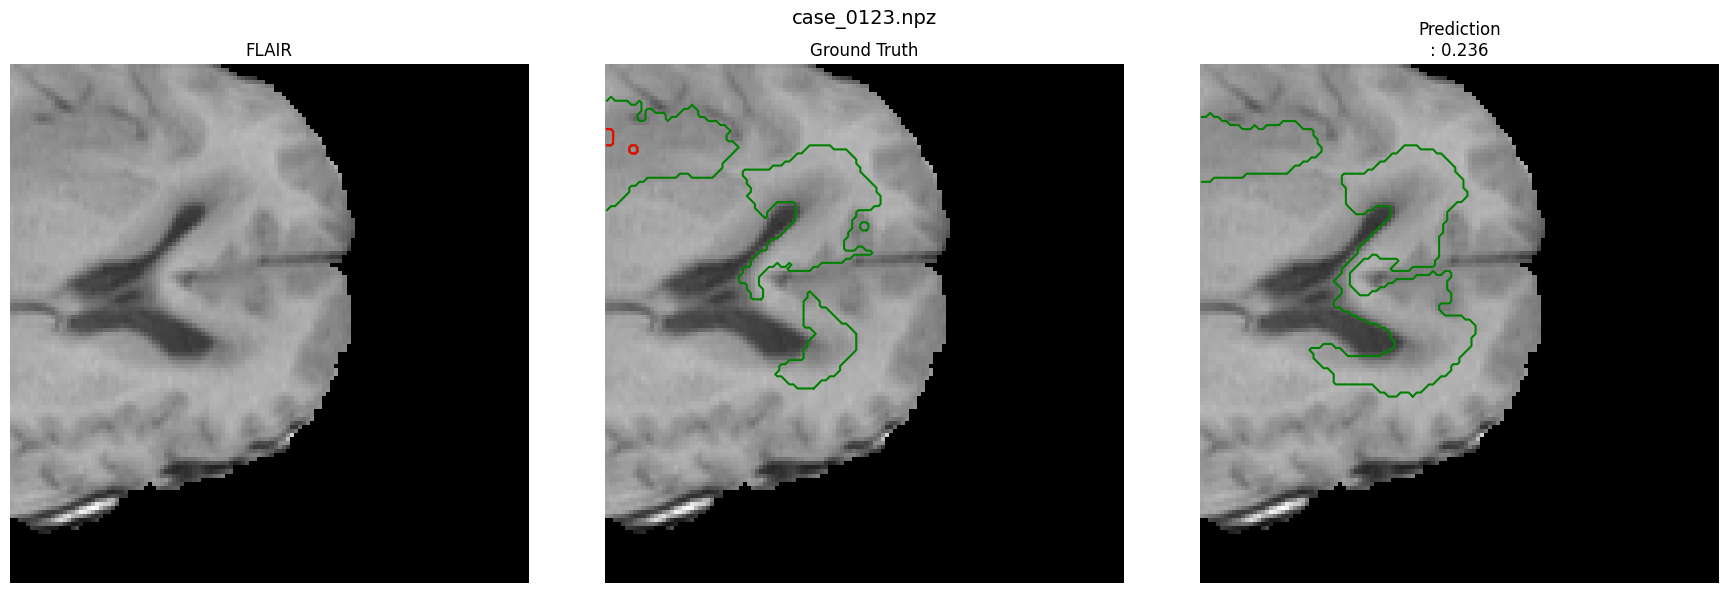

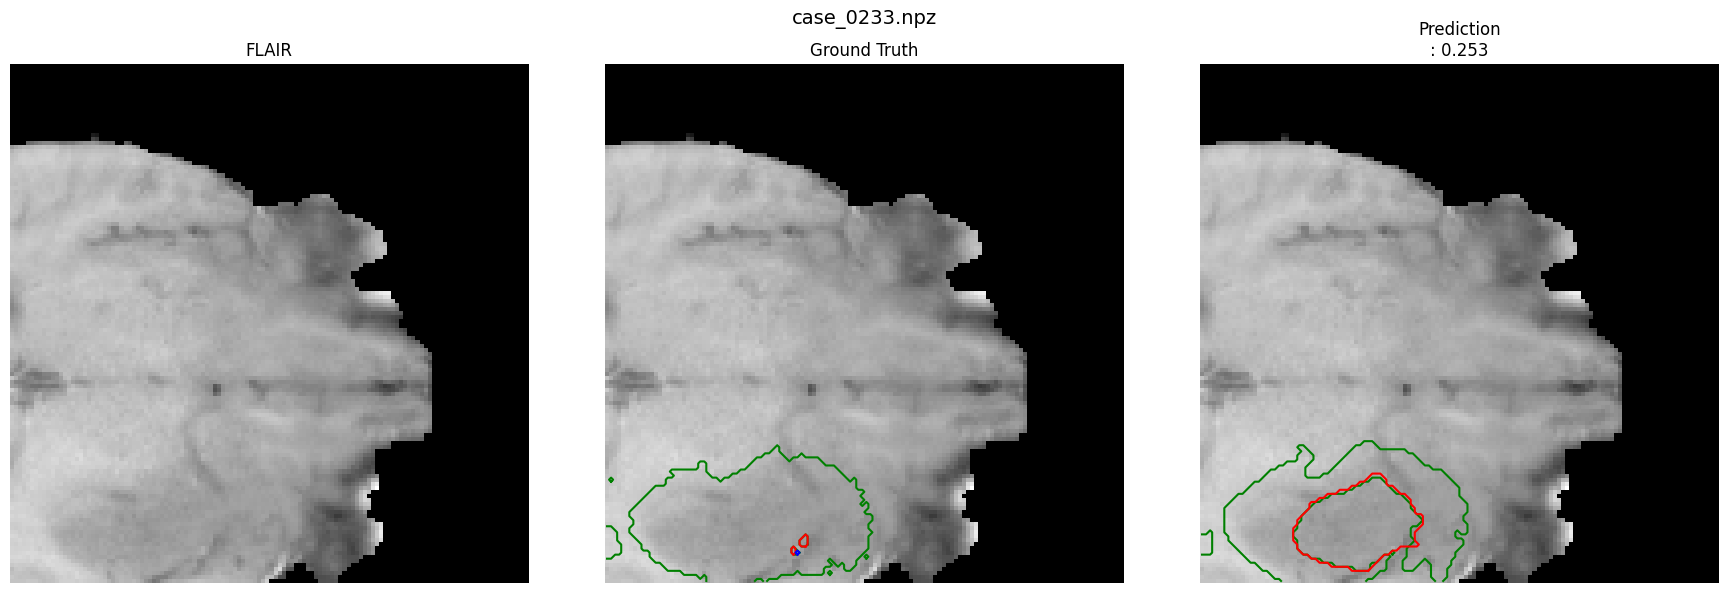

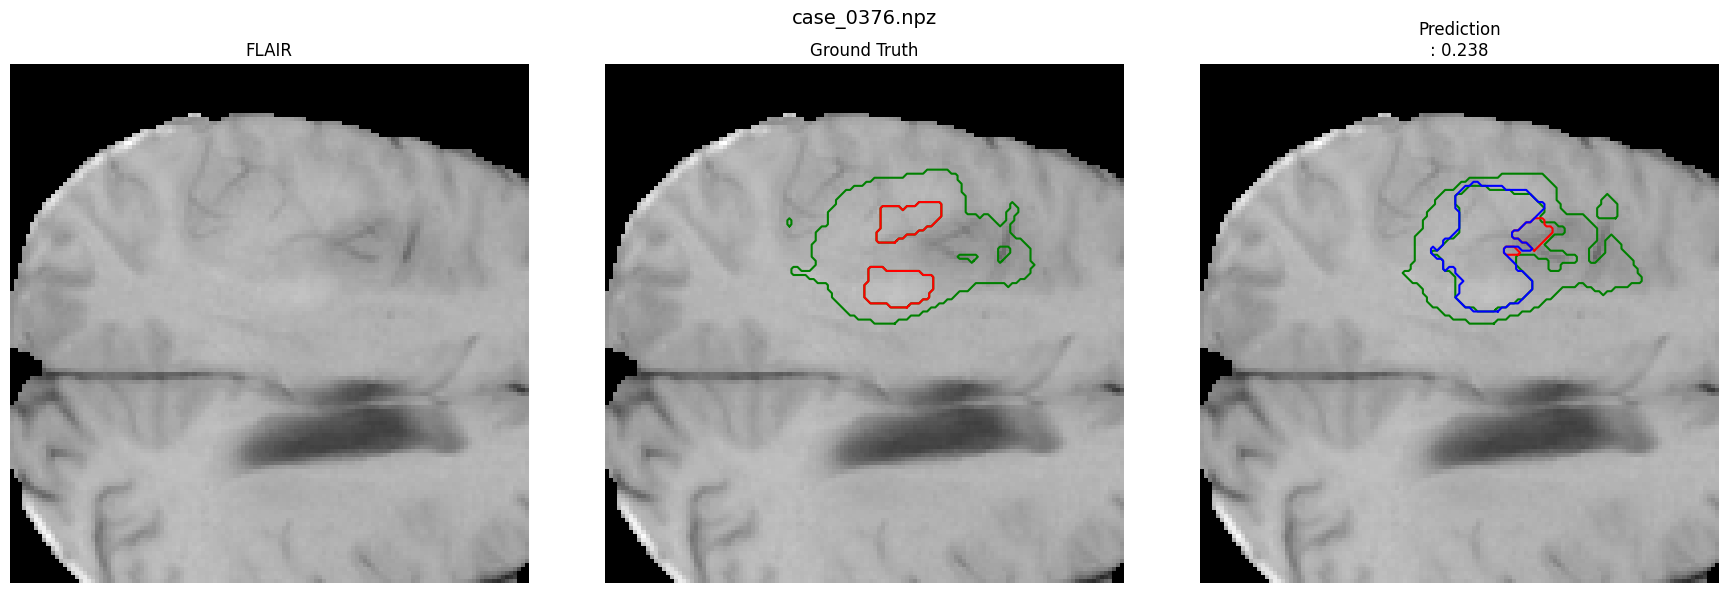

In [15]:
folder = PREDICTIONS_DIR / "worst_dice"
files = sorted(folder.glob("*.npz"))

for file in files:
    visualize_case(file, slice_idx=8)

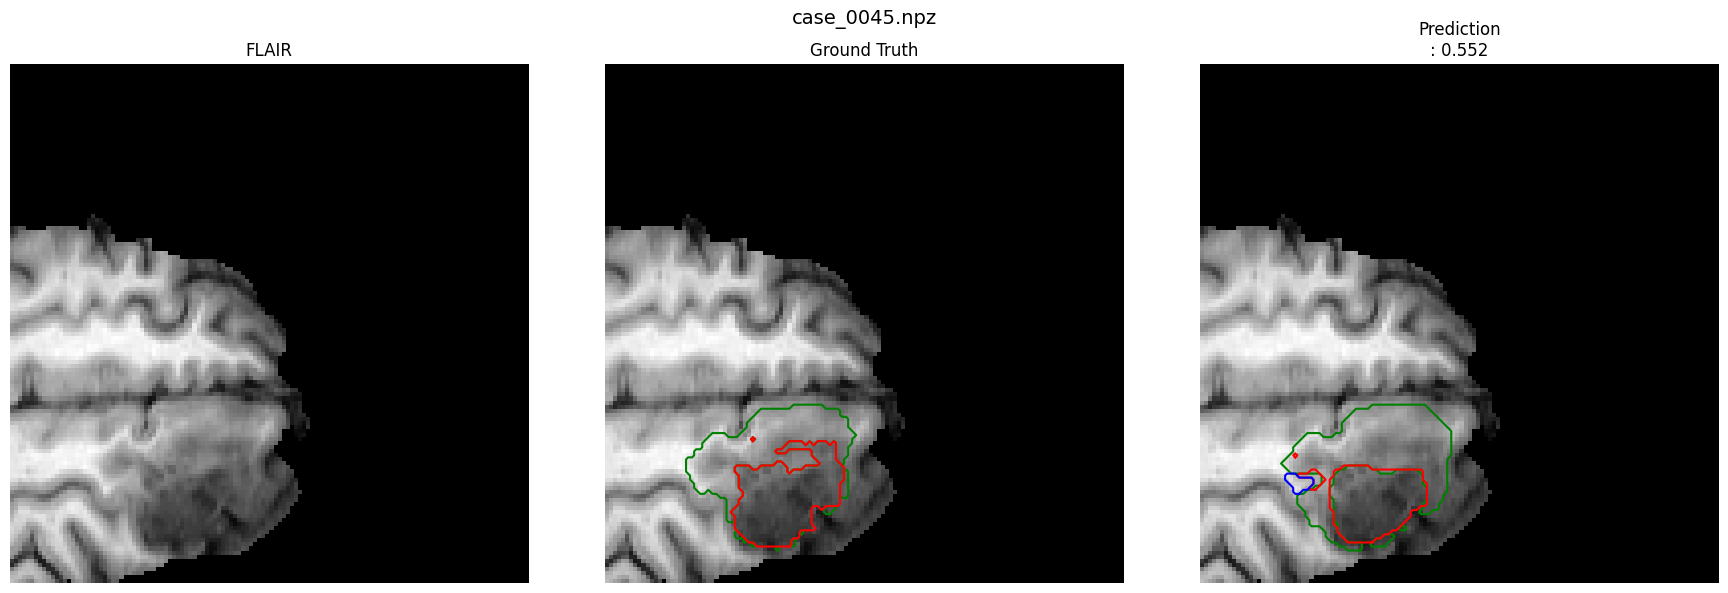

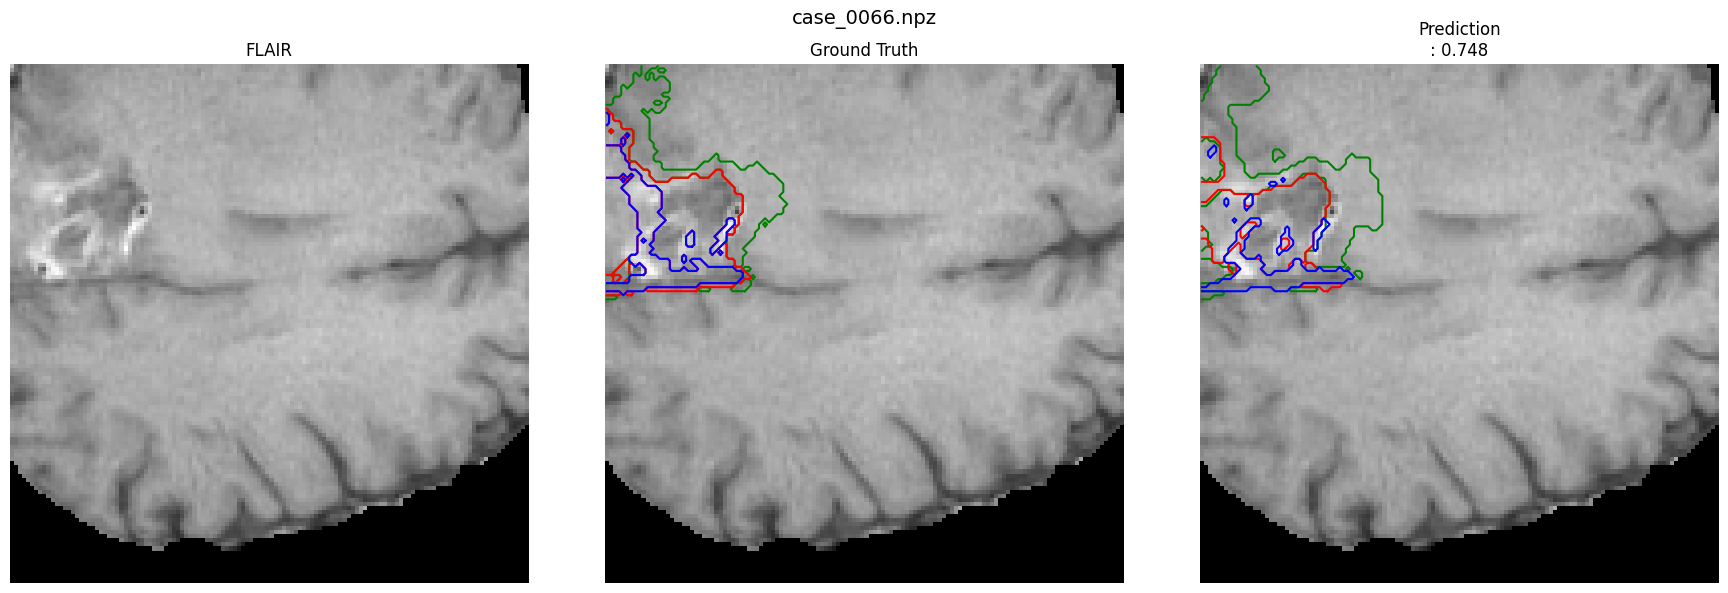

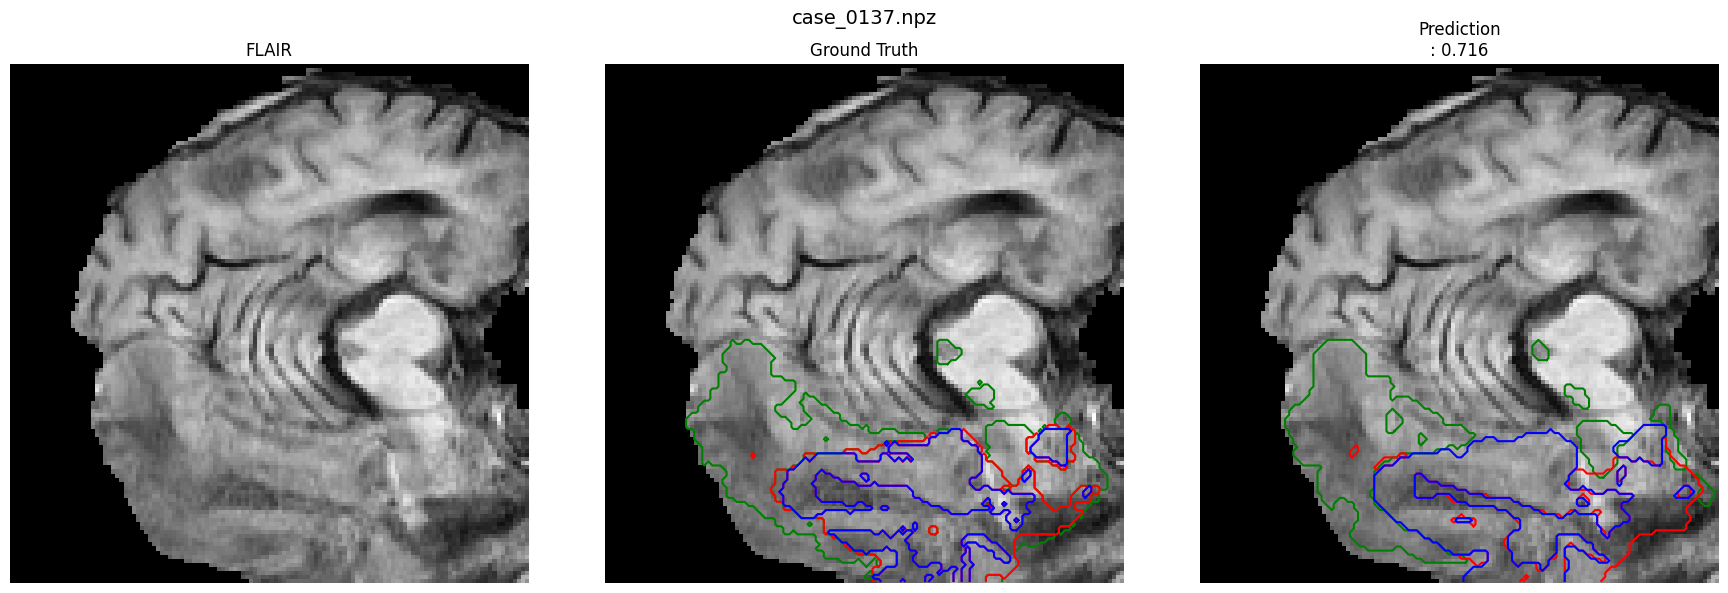

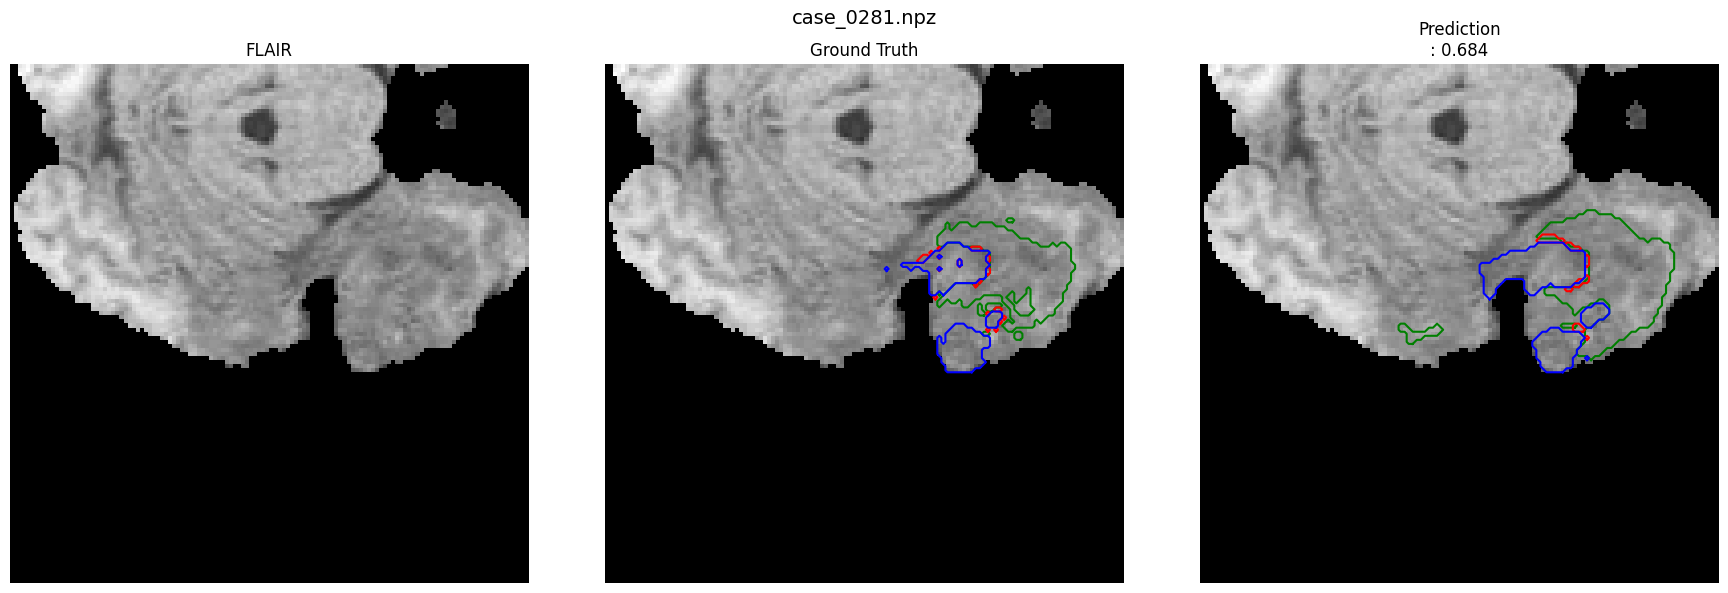

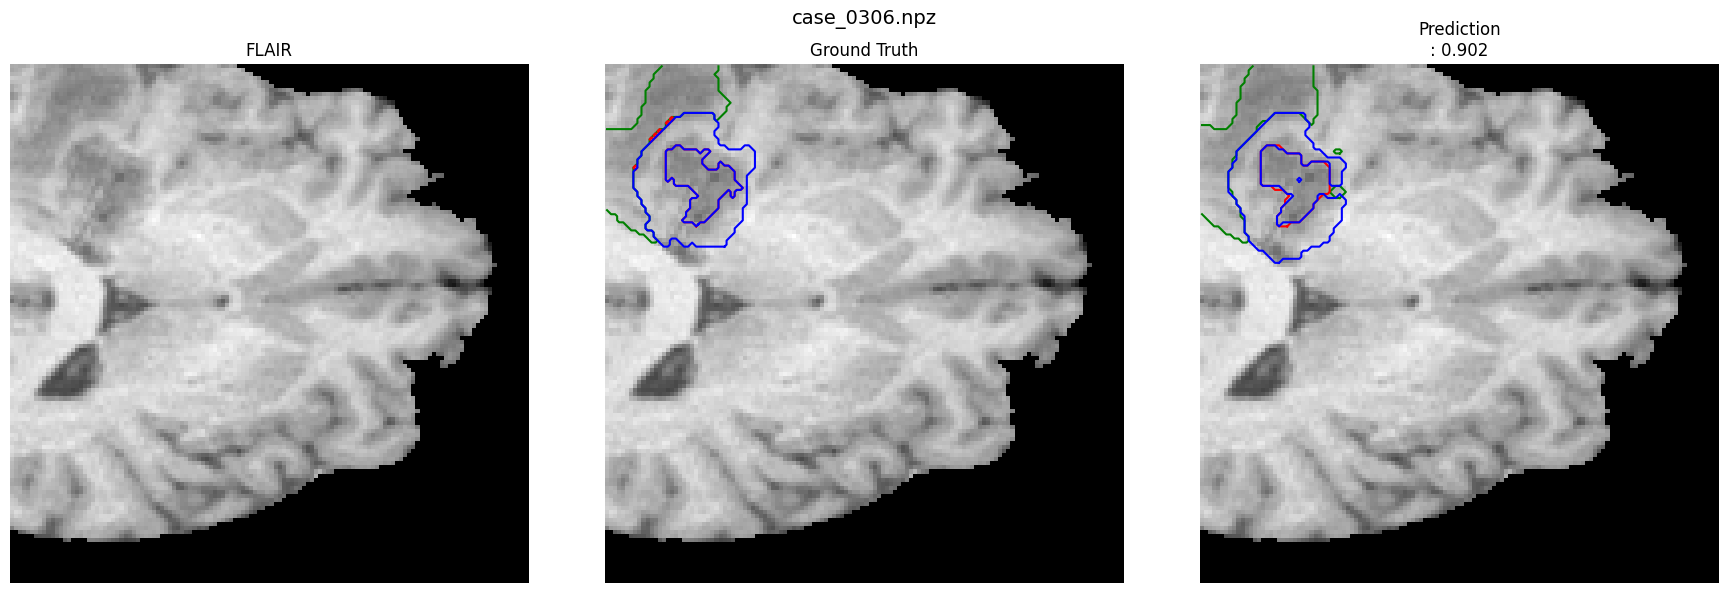

In [16]:
folder = PREDICTIONS_DIR / "class_EC"
files = sorted(folder.glob("*.npz"))

for file in files:
    visualize_case(file, slice_idx=8)

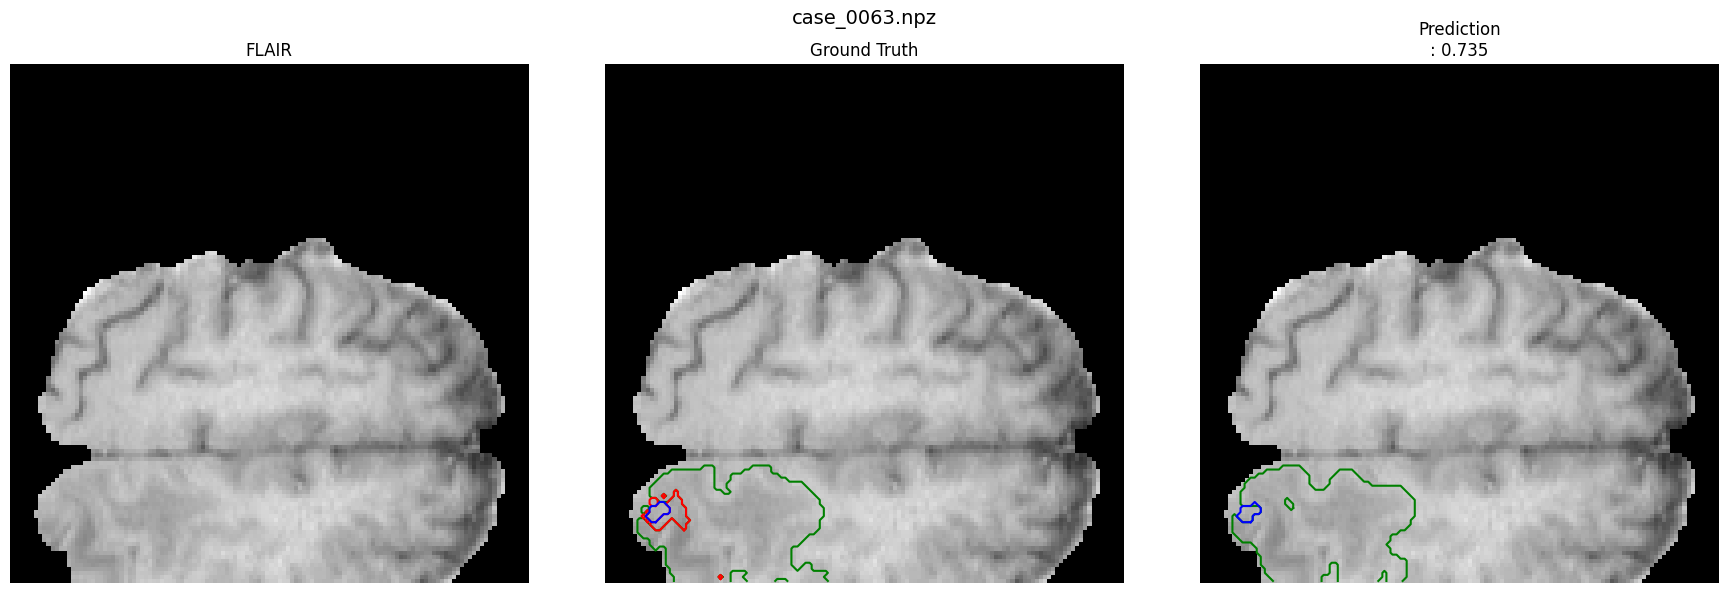

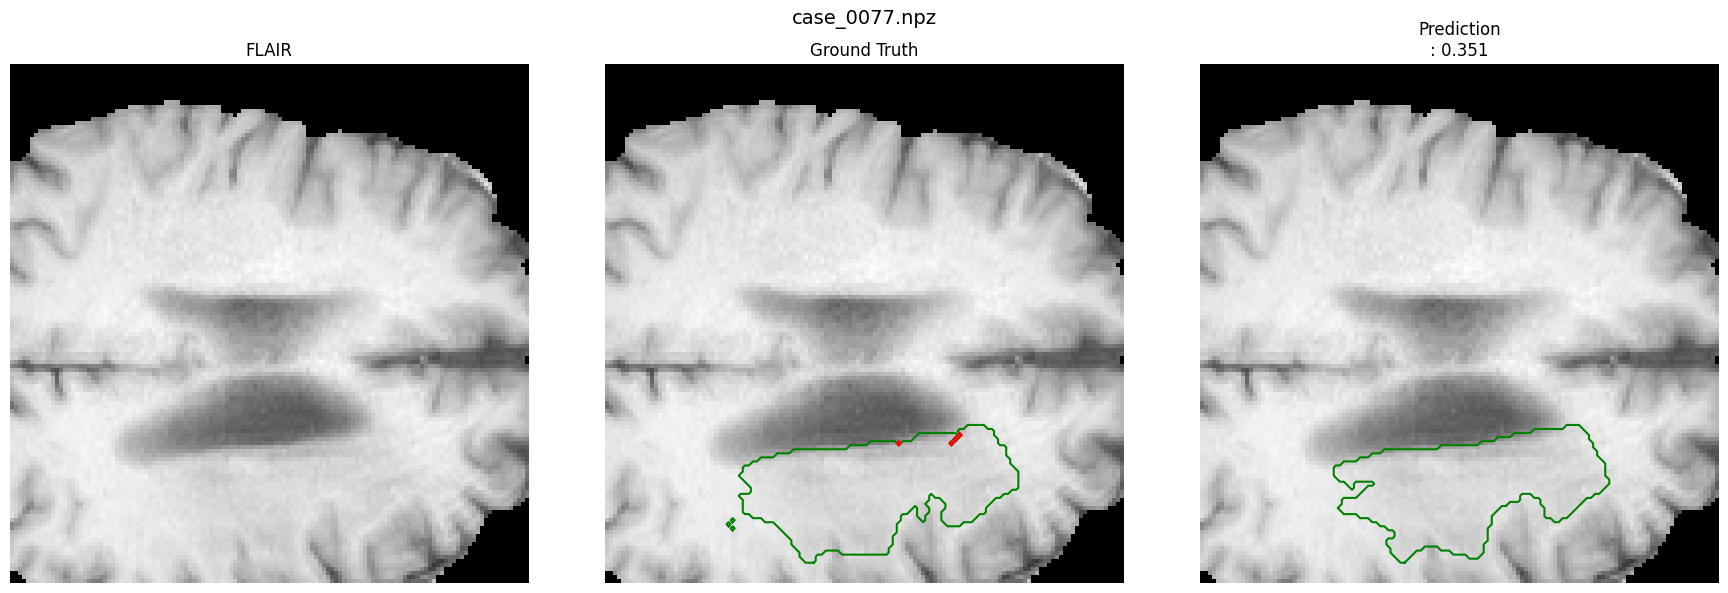

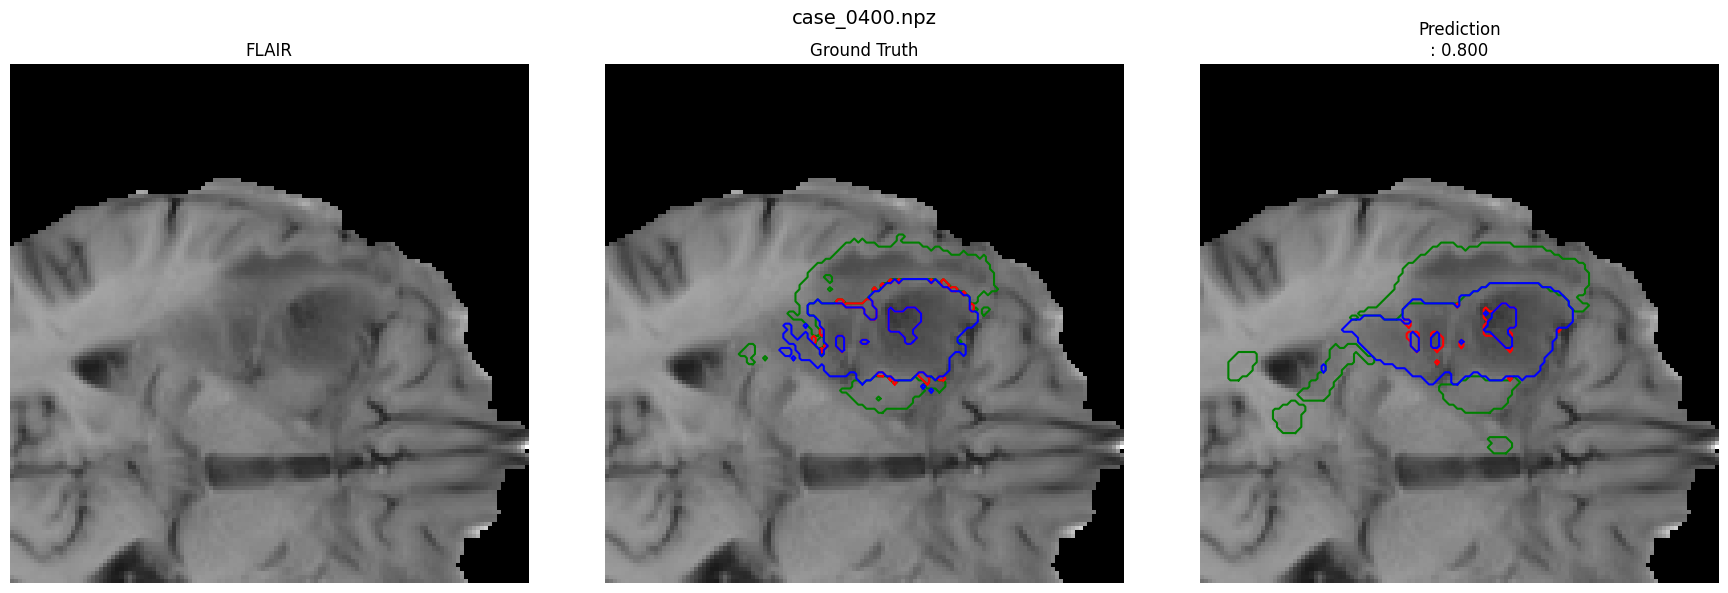

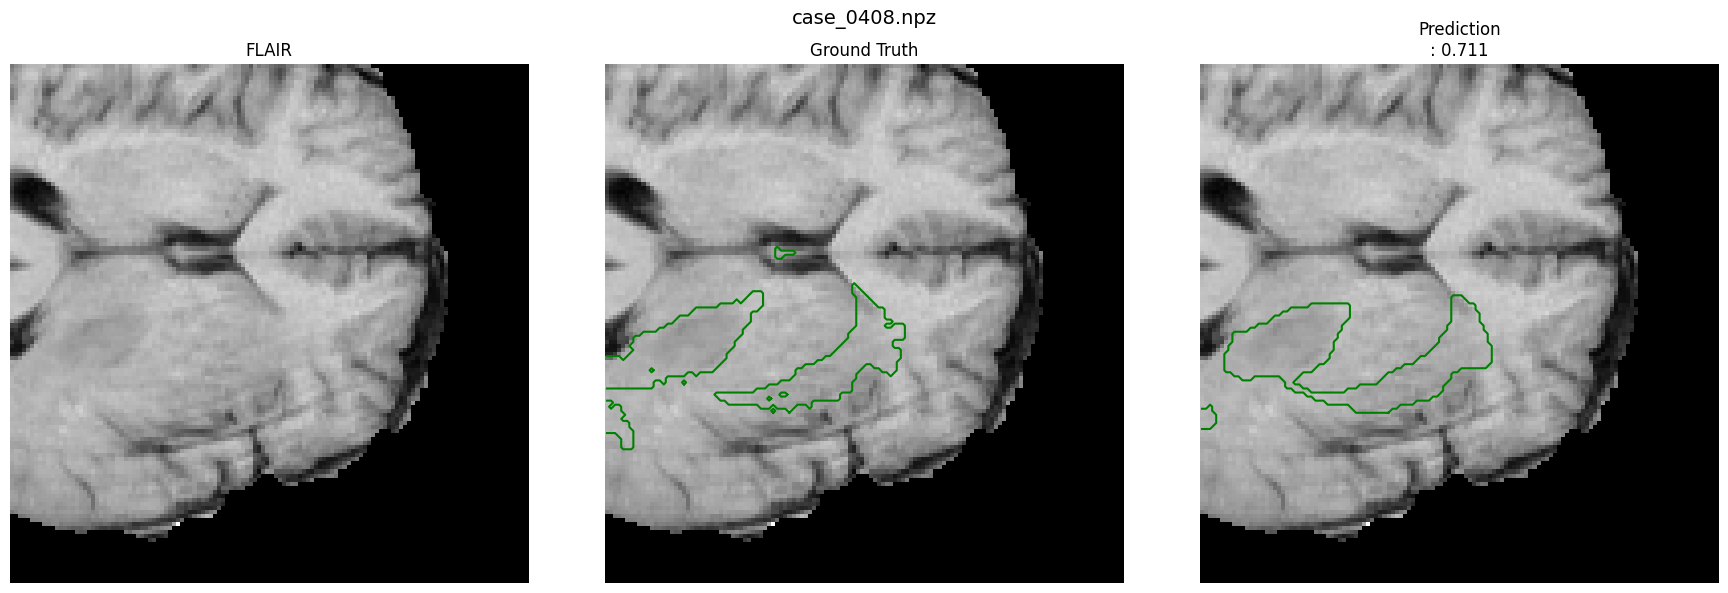

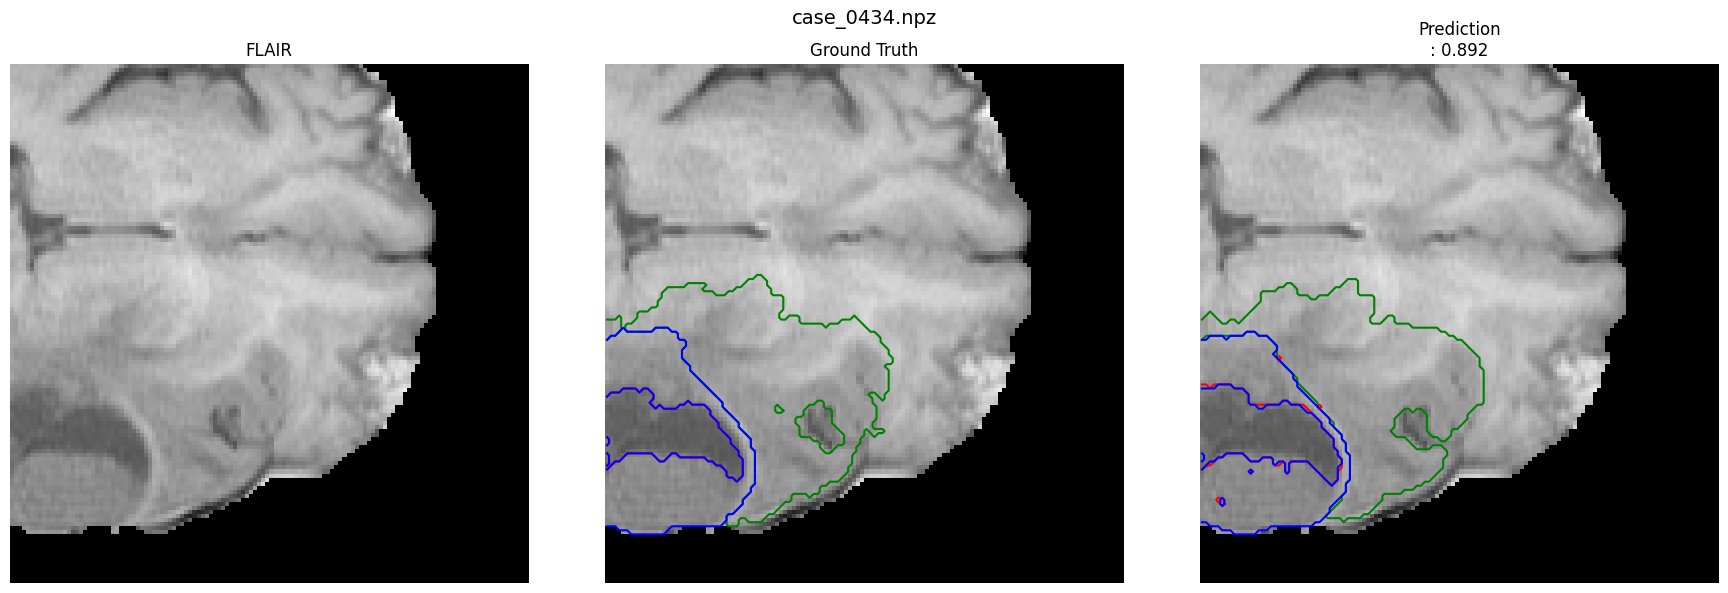

In [17]:
folder = PREDICTIONS_DIR / "class_TC"
files = sorted(folder.glob("*.npz"))

for file in files:
    visualize_case(file, slice_idx=8)

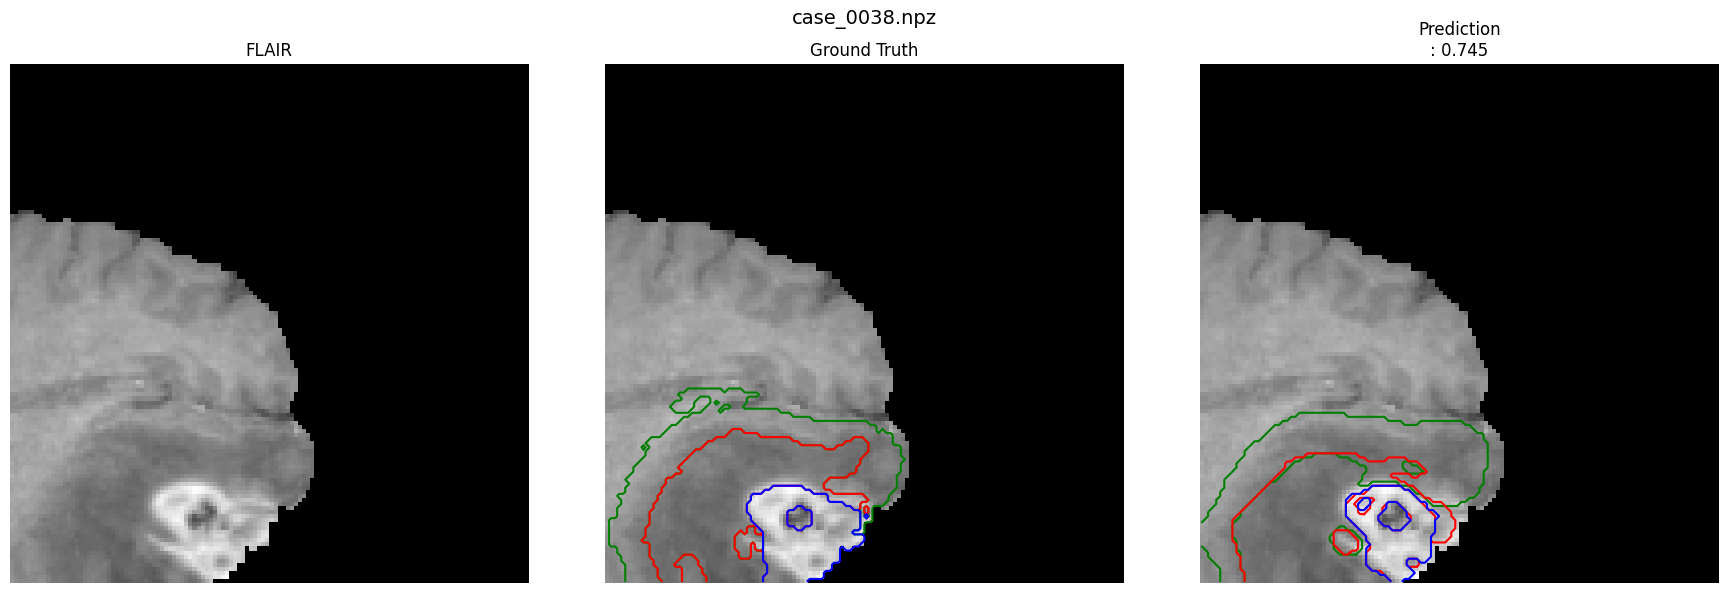

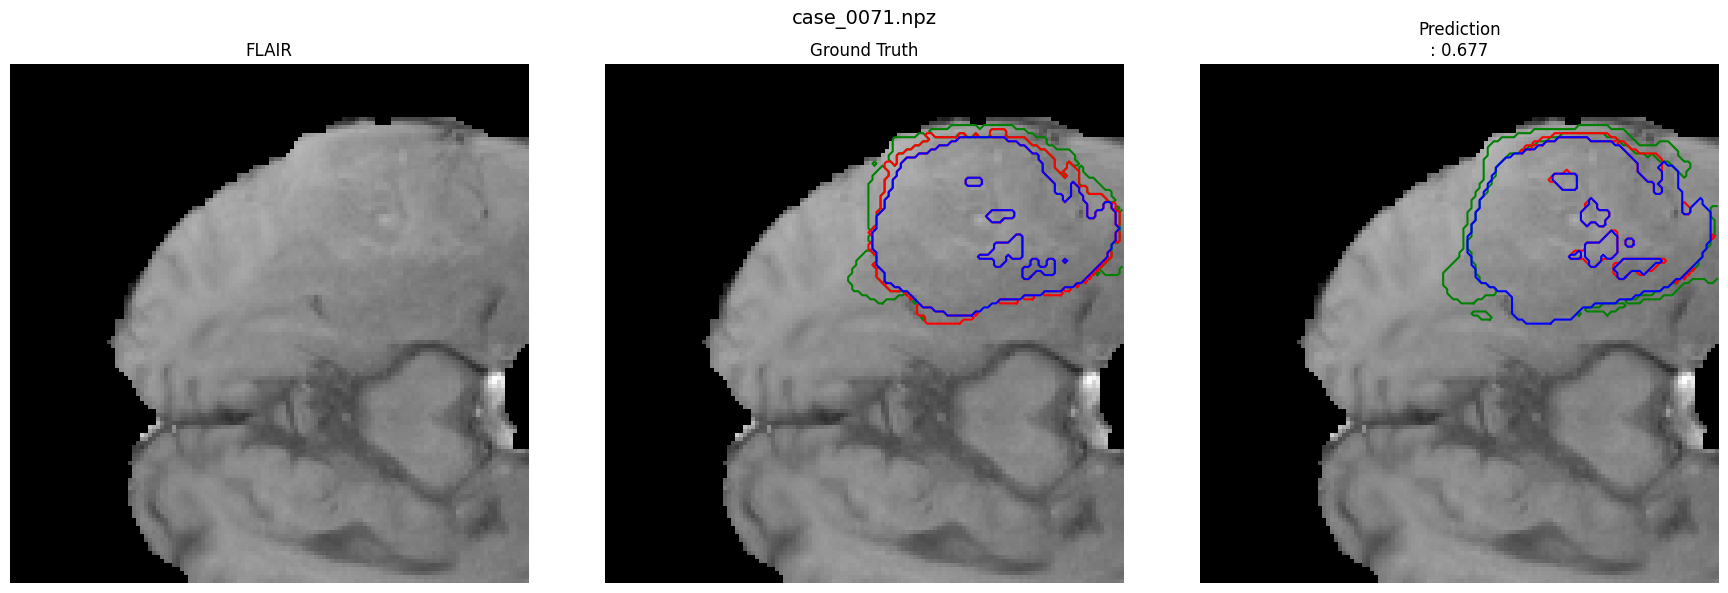

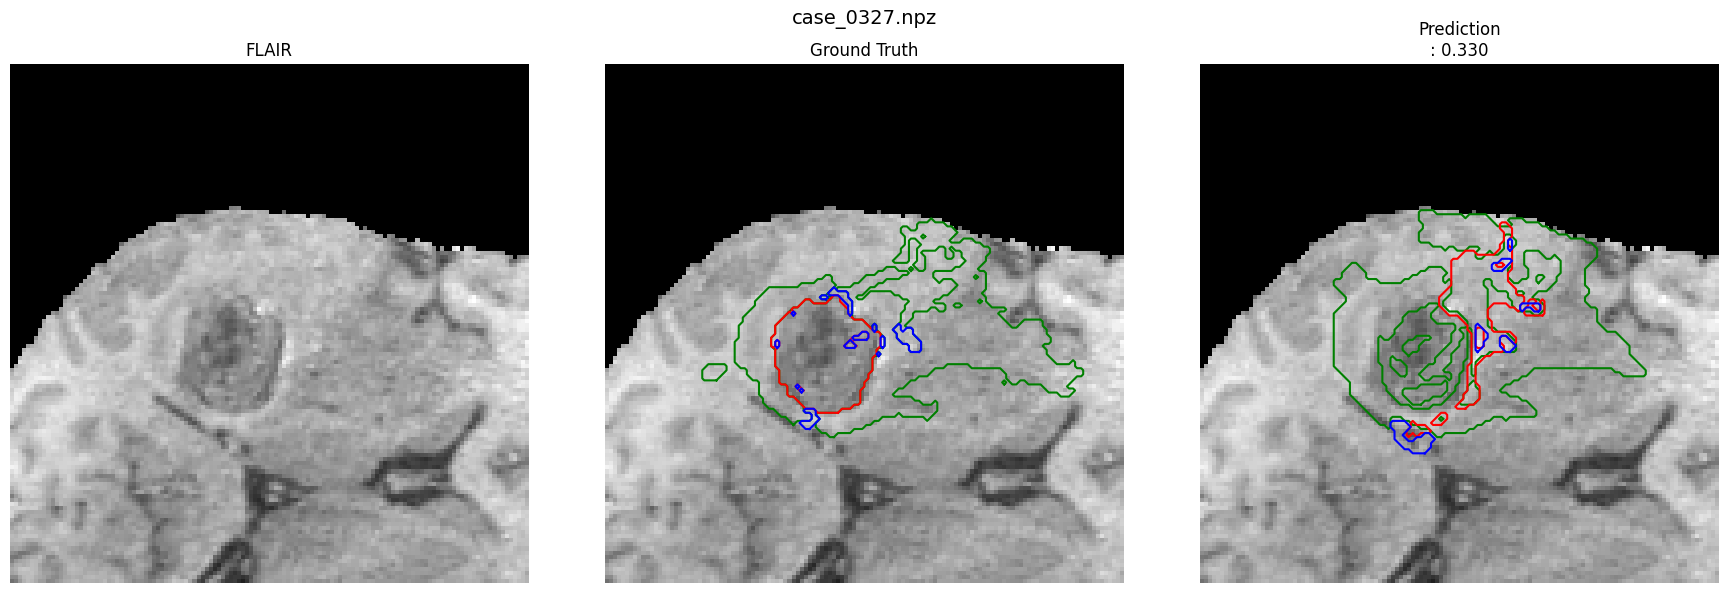

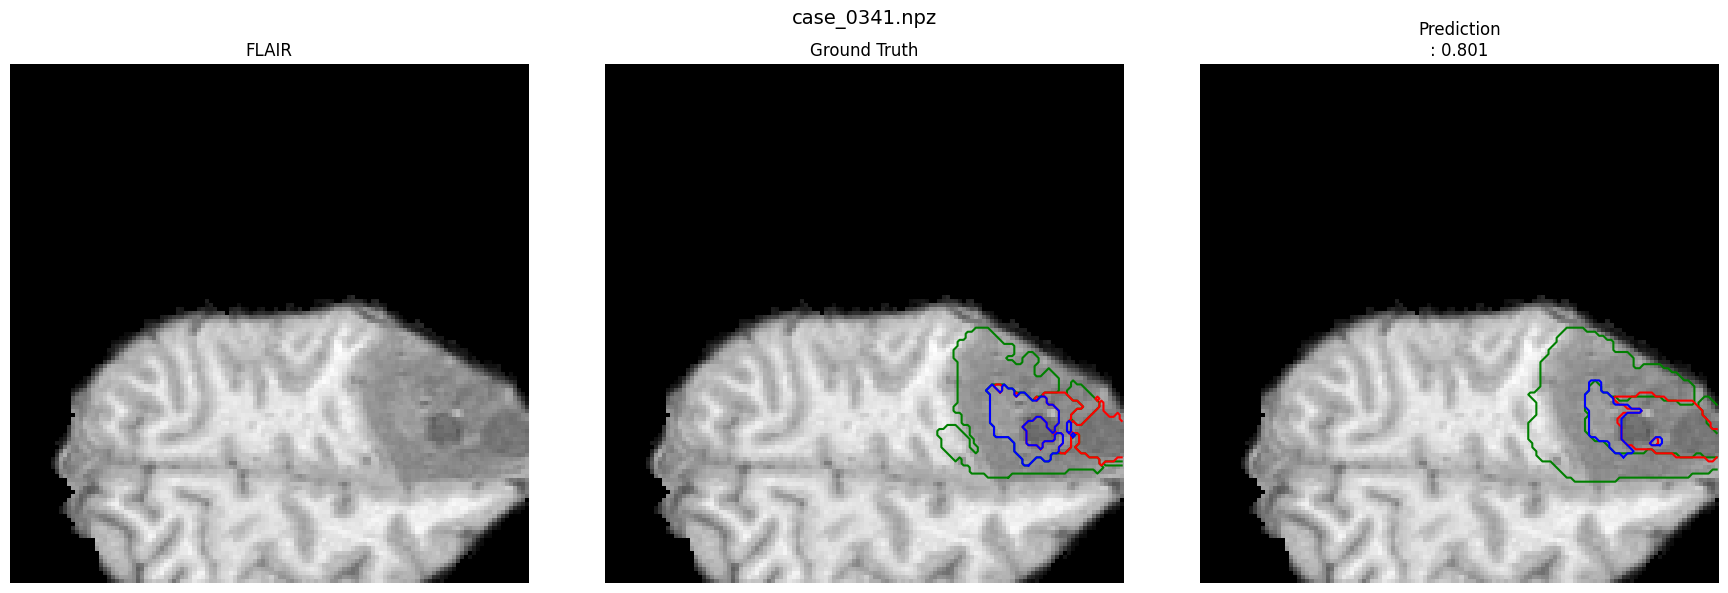

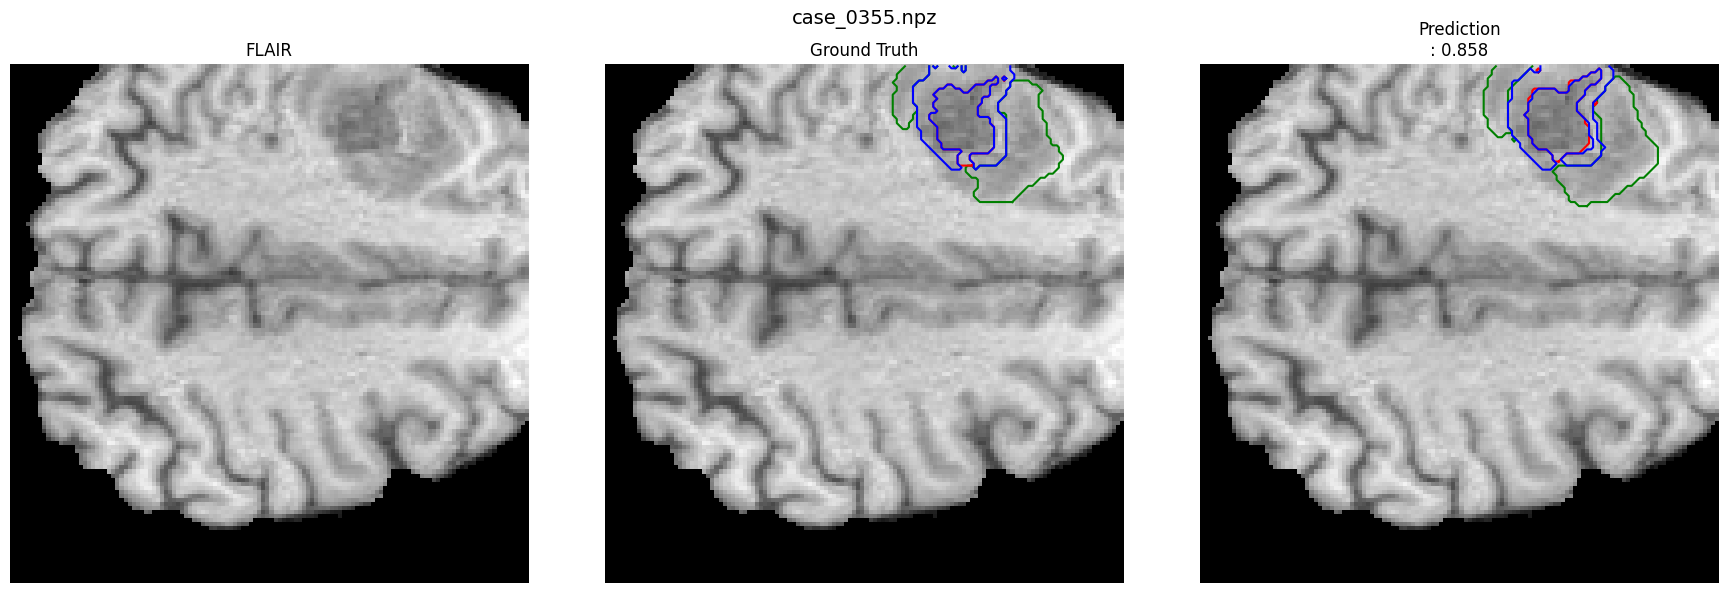

In [18]:
folder = PREDICTIONS_DIR / "class_WT"
files = sorted(folder.glob("*.npz"))

for file in files:
    visualize_case(file, slice_idx=8)